In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pv_model_210131 as pv
import pv_model_class


In [11]:
# Constants and variables

Iscn = 8.21 #8.7 # nominal short circuit current
Vocn = 32.9 #37.7 # nominal open circuit voltage
Imp = 7.61 #8.2 # array current at MPP
Vmp = 26.3 #30.1 # array voltage at MPP
Pmax_e = Vmp * Imp # experimental array max power output
Kv = -0.123 #-0.32/100 * Vocn # voltage temperature coefficient
Ki = 0.0032 #-0.032/100 * Iscn # current temperature coefficient
Ns = 54 #60. # number of series cells
Gn = 1000. # nominal irradiance
Tn = 25. + 273.15 # nominal operating temperature

Egap = 1.8 * 10 ** -19 # Bandgap of silicon (silicio cristalino)

q = 1.602 * 10 ** -19 # charge on electron
k = 1.3806503 * 10 ** -23 # boltzmann constant
err = 0.001


In [14]:
# Main code block for developing iterative appraoch to
# solving for Rs, Rp, and `a`

G = Gn 
T = Tn 
Vtn = k * Tn / q
Vt = k * T / q
deltaT = T - Tn

# Hard coding a to 1.3 (and taking out a equation) gets correct results
a = 1.3

Rs_max = (Vocn - Vmp) / Imp
Rp_min = Vmp / (Iscn - Imp) - Rs_max

Rp = Rp_min
Rs_vals = np.arange(0, Rs_max, 0.001)
itr = 0
v = np.arange(0.1, Vocn, 0.1)
#i = np.arange(Iscn, 0, -0.1)
i = np.zeros_like(v)

p_dif = Pmax_e
Rp_prev = Rp

itr1 = 0

while p_dif >= err and itr < len(v):
    #print("outer")
    Rs = Rs_vals[itr]
    
    Ipvn = Iscn * (Rs+Rp)/Rp 
    Ipv = (Ipvn + Ki*deltaT) * G/Gn
    Isc = (Iscn + Ki*deltaT) * G/Gn
    I0n = (Ipv - Vocn/Rp) / (math.exp(Vocn/Vt/a/Ns)-1)
    I0 = I0n
    
    # a is hard coded above
    #a = (Kv - Vocn/Tn) / (Ns * Vtn * (Ki/Ipvn - 3./Tn - Egap/(k*(Tn**2))))
    
    Rp = Vmp * (Vmp + Imp*Rs) / (Vmp * Ipv - Vmp* I0 * math.exp((Vmp+Imp*Rs)/Vt/Ns/a)+Vmp*I0-Pmax_e)
    
    _i = i[0]
    for idx in range(len(v)):
        _v = v[idx]
        _g = Ipv - I0 * (math.exp((_v + _i*Rs)/Vt/Ns/a)-1) - (_v + _i*Rs)/Rp - _i
        while abs(_g) > err:
            itr1 += 1
            _g = Ipv - I0 * (math.exp((_v + _i*Rs)/Vt/Ns/a)-1) - (_v + _i*Rs)/Rp - _i
            _glin = -I0 * Rs/Vt/Ns/a * math.exp((_v + _i*Rs)/Vt/Ns/a) - Rs/Rp - 1
            _i = _i - _g/_glin
            i[idx] = _i
     
    P = np.zeros_like(v)
    
    for idx1 in range(len(v)):
        P[idx1] = v[idx1] * i[idx1]
    P_idx = np.argmax(P)
    Pmax_m = P[P_idx]
    
    p_dif = Pmax_m - Pmax_e
    itr += 1
print(Rs, Rp, a)
print(Pmax_m, p_dif)

0.223 412.19607122515566 1.3
200.1435799356833 0.0005799356833051661


### Output (non-iterative a)

Rs = 0.371, Rp = 586.75, Pmax_m = 246.82036, Pmax_e = 246.82, p_dif = 0.00036, a = 1

### Output (iterative a)
Rs = 0.363, Rp = 705.275, Pmax_m = 246.8207, Pmax_e = 246.82, p_dif = 0.00072, a = 1.0205144336274015

0.301 175.67888113901455 1.078858619204327


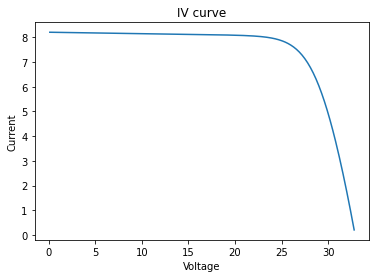

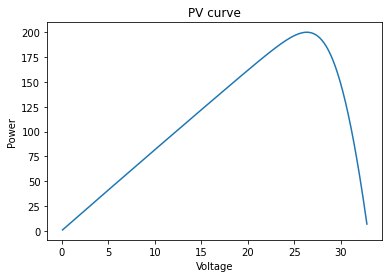

Maximum Power: 200.1335633429264
Maximum v, i: 26.300000000000004 , 7.60964119174625


In [16]:
# utilize PvModel class to intialize model and plot IV and PV curves

pv_mod = pv_model_class.PvModel(Iscn, Vocn, Imp, Vmp, Kv, Ki, Ns, Gn, Tn, Egap, 0.0001)
Rs, Rp, a = pv_mod.find_resistors()
print(Rs, Rp, a)
v, i, P = pv_mod.power(Rs, Rp, a)

pv_mod._plot(v, i, 'Voltage', 'Current', 'IV curve')
pv_mod._plot(v, P, 'Voltage', 'Power', 'PV curve')
P_max = np.argmax(P)
print('Maximum Power:', P[P_max])
print('Maximum v, i:', v[P_max],",",i[P_max])

In [ ]:
# plot IV curve
fig1 = plt.figure(1)
plt.plot(v, i)
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.title('IV curve')
plt.show()

In [ ]:
# plot PV curve
fig2 = plt.figure(1)
plt.plot(v, P)
plt.title('PV curve')
plt.xlabel('Voltage')
plt.ylabel('Power')
plt.show()

In [ ]:
# plot IV and PV curves on shared x-axis
fig1 = plt.figure(2)
plt.title('PV and IV curves')

ax1 = fig1.add_subplot(1,1,1)
plt.plot(v, i, 'b')
plt.ylabel('Current', color='b')

ax2 = ax1.twinx()
plt.plot(v, P,'g')
plt.ylabel('Power', color='g')
plt.xlabel('Voltage')

plt.show()

### Next steps:

Check values to the Villalva paper -- why are they so much larger?
<br>
Finalize plotting function, add in subplot functionality?
<br>
Clean up how variables are set in code and each function, including how data is loaded in